In [30]:
# Tick History PCAP, SQL request API :
import maystreet_data

# Refinitiv Data Platform API :
import refinitiv.data as rd

import pandas as pd 
import numpy as np 
import datetime as dt
from scipy.stats import norm
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm


In [31]:
### Date used for Historical Data Simulation 
date = "2024-04-10"
date2 = "2024-04-11"

### Option used for the Simulation
option_name = 'BMW SI 20241220 PS AM C 100.00 0'

In [32]:
### Using PCAP Normalized Data to download one option price with timestamp
def query_apu():
    return f"""
    SELECT
        dt, product, f,  firstexchangetimestamp, bidprice_1, askprice_1
    FROM
        "prod_lake"."p_mst_data_lake"."mt_aggregated_price_update"
    WHERE
        f='emdi_eurex_t7'
        AND dt= '{date}'
        AND product = '{option_name}'
    ORDER BY
        firstexchangetimestamp
"""
records_iter = maystreet_data.query(maystreet_data.DataSource.DATA_LAKE, query_apu())
df_option = pd.DataFrame(records_iter)
df_option['firstexchangetimestamp'] = pd.to_datetime(df_option.firstexchangetimestamp)
df_option = df_option.rename(columns = {
                    'product' : 'opt',
                    'bidprice_1' : 'opt_bid',
                    'askprice_1' : 'opt_ask',
                    'firstexchangetimestamp' : 'opt_timestamp'
                    })
df_option = df_option.drop(['f', 'dt'], axis = 1)
df_option['opt_avg'] = (df_option['opt_bid'] + df_option['opt_ask']) / 2
df_option.head()

,opt,opt_timestamp,opt_bid,opt_ask,opt_avg
0,BMW SI 20241220 PS AM C 100.00 0,2024-04-10 07:01:00.155434595,2.00,NaN,NaN
1,BMW SI 20241220 PS AM C 100.00 0,2024-04-10 07:01:44.491119335,15.10,18.25,16.675
2,BMW SI 20241220 PS AM C 100.00 0,2024-04-10 07:01:45.790763944,15.10,18.30,16.700
3,BMW SI 20241220 PS AM C 100.00 0,2024-04-10 07:01:55.491631111,15.15,18.30,16.725
4,BMW SI 20241220 PS AM C 100.00 0,2024-04-10 07:02:07.492697527,15.15,18.25,16.700


In [33]:
rd.open_session(config_name='../pwd/session.json')

/home/workbench/.virtualenv/lib/python3.11/site-packages/refinitiv/data/_access_layer/session.py:71:FutureWarning: 
You open a platform session using the default value of the signon_control parameter (signon_control=True).
In future library version v2.0, this default will be changed to False.
If you want to keep the same behavior as today, you will need to set the signon_control parameter to True either in the library configuration file
({'sessions':{'platform':{'your_session_name':{'signon_control':true}}}}) or in your code where you create the Platform Session.
These alternative options are already supported in the current version of the library.


<refinitiv.data.session.Definition object at 0x7f49ba57fb10 {name='rdp'}>

In [34]:
df_BMW =  rd.get_history(
    universe=['BMWG.DE'],
    fields=["TRDPRC_1"],
    interval="tick",
    start=date,
    end=date2)
df_BMW = df_BMW.reset_index()
df_BMW = df_BMW.rename(columns = {
                    'TRDPRC_1' : 'underlying_trade_price',
                    'Timestamp' : 'underlying_timestamp'
                    })
df_BMW.head()

BMWG.DE,underlying_timestamp,underlying_trade_price
0,2024-04-10 02:20:01.049,<NA>
1,2024-04-10 05:31:26.238,<NA>
2,2024-04-10 06:50:00.085,113.0
3,2024-04-10 06:50:00.085,<NA>
4,2024-04-10 06:50:00.085,<NA>


In [35]:
### Merge Option price df, and underlying price df
df = pd.merge_asof(df_option, df_BMW, left_on= "opt_timestamp", right_on="underlying_timestamp" , direction = 'nearest')
df.head()

,opt,opt_timestamp,opt_bid,opt_ask,opt_avg,underlying_timestamp,underlying_trade_price
0,BMW SI 20241220 PS AM C 100.00 0,2024-04-10 07:01:00.155434595,2.00,NaN,NaN,2024-04-10 07:01:02.420,<NA>
1,BMW SI 20241220 PS AM C 100.00 0,2024-04-10 07:01:44.491119335,15.10,18.25,16.675,2024-04-10 07:01:45.658,<NA>
2,BMW SI 20241220 PS AM C 100.00 0,2024-04-10 07:01:45.790763944,15.10,18.30,16.700,2024-04-10 07:01:45.741,<NA>
3,BMW SI 20241220 PS AM C 100.00 0,2024-04-10 07:01:55.491631111,15.15,18.30,16.725,2024-04-10 07:01:55.480,<NA>
4,BMW SI 20241220 PS AM C 100.00 0,2024-04-10 07:02:07.492697527,15.15,18.25,16.700,2024-04-10 07:02:07.493,<NA>


### Call OPtion Price - Black Schole Model
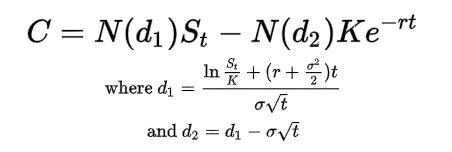

C = call option price <br>
N = CDF of the normal distribution<br>
St= spot price of an asset<br>
K = strike price<br>
r = risk-free interest rate<br>
t = time to maturity<br>
σ = volatility of the asset<br>

In [36]:
### Fixing some parameters
r = 0.003
N = norm.cdf
N_prime = norm.pdf
sigma = np.sqrt(252) * 0.015304757885578736
K = 100
exp_date = dt.datetime(2023, 12, 15, 0, 0) #'2023-12-15'
today_date = dt.datetime(2023, 6, 28, 0, 0)
T = ((exp_date - today_date).days) / 365

In [37]:
df = df.dropna(subset='underlying_trade_price')

In [38]:
def black_scholes_call(S, K, T, r, sigma):
    '''
    :param S: Asset price
    :param K: Strike price
    :param T: Time to maturity
    :param r: risk-free rate (treasury bills)
    :param sigma: volatility
    :return: call price
    '''
    d1 = (np.log(S / K) + (r + sigma ** 2 / 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call = S * N(d1) -  N(d2)* K * np.exp(-r * T)
    return call


df['opt_estimated_price'] = df.underlying_trade_price.apply(black_scholes_call, args = (K, T, r, sigma))
df.head()


,opt,opt_timestamp,opt_bid,opt_ask,opt_avg,underlying_timestamp,underlying_trade_price,opt_estimated_price
38,BMW SI 20241220 PS AM C 100.00 0,2024-04-10 07:03:04.062378958,16.45,17.3,16.875,2024-04-10 07:03:04.061,114.9,17.002496
77,BMW SI 20241220 PS AM C 100.00 0,2024-04-10 07:04:52.587209770,16.45,17.3,16.875,2024-04-10 07:04:52.587,114.9,17.002496
92,BMW SI 20241220 PS AM C 100.00 0,2024-04-10 07:05:05.009868762,16.40,17.3,16.850,2024-04-10 07:05:05.009,114.8,16.920208
113,BMW SI 20241220 PS AM C 100.00 0,2024-04-10 07:06:14.966621205,15.95,17.3,16.625,2024-04-10 07:06:14.967,114.75,16.879116
115,BMW SI 20241220 PS AM C 100.00 0,2024-04-10 07:06:15.037783091,15.95,17.3,16.625,2024-04-10 07:06:15.039,114.65,16.797034


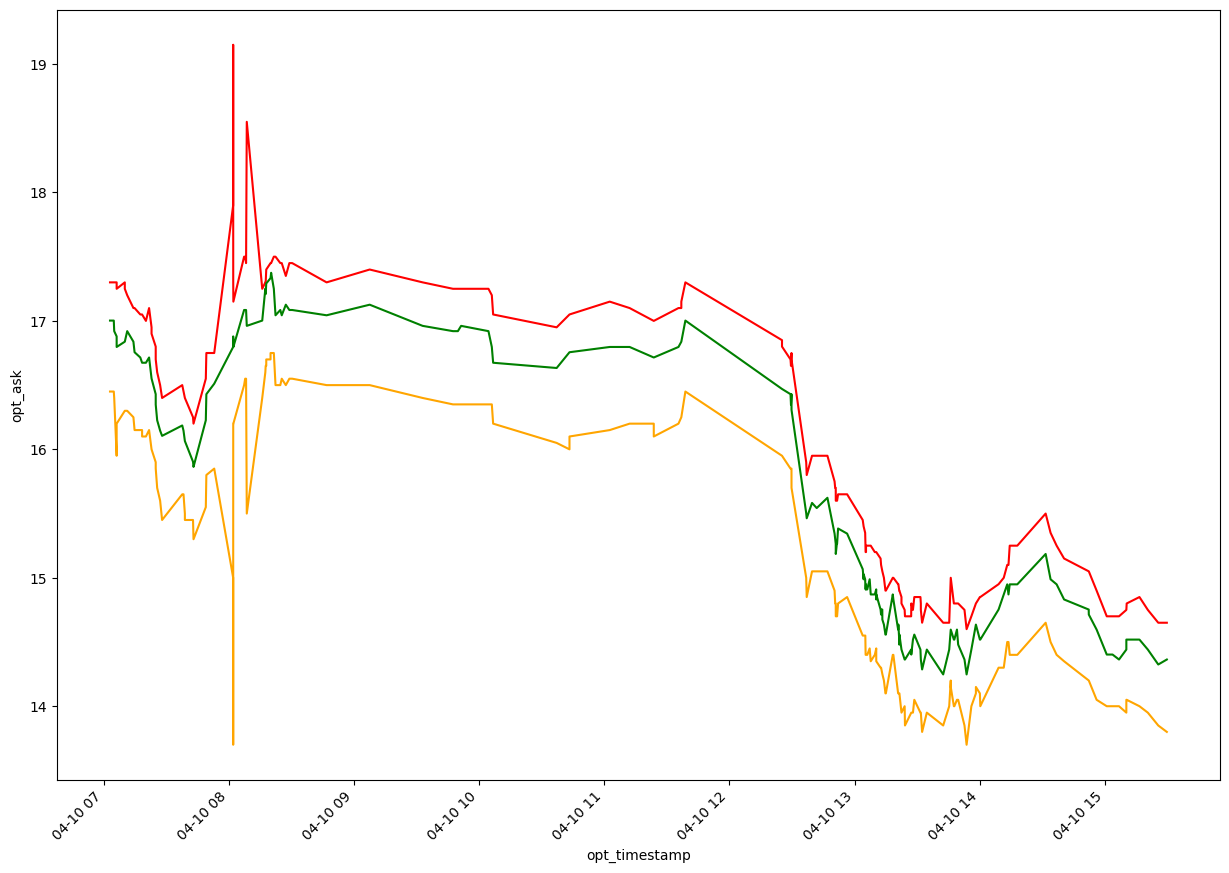

In [39]:
fix, ax = plt.subplots(figsize=(15,10))
sns.lineplot(df, x = 'opt_timestamp', y = 'opt_ask', color = 'red')
sns.lineplot(df, x = 'opt_timestamp', y = 'opt_bid', color = 'orange')
sns.lineplot(df, x = 'opt_timestamp', y = 'opt_estimated_price', color = 'green')
plt.xticks(rotation=45, ha='right')
plt.show()

## Implied Volatility Calculation using Newton-Raphson Method

In [40]:
def vega(S, K, T, r, sigma):
    '''
    :param S: Asset price
    :param K: Strike price
    :param T: Time to Maturity
    :param r: risk-free rate (treasury bills)
    :param sigma: volatility
    :return: partial derivative w.r.t volatility
    '''
    d1 = (np.log(S / K) + (r + sigma ** 2 / 2) * T) / sigma * np.sqrt(T)
    vega = S * N_prime(d1) * np.sqrt(T)
    return vega


def implied_volatility_call(C, S, K, T, r, sigma, tol=0.0001, max_iterations=100):
    '''
    :param C: Observed call price
    :param S: Asset price
    :param K: Strike Price
    :param T: Time to Maturity
    :param r: riskfree rate
    :param tol: error tolerance in result
    :param max_iterations: max iterations to update vol
    :return: implied volatility in percent
    '''
    for i in range(max_iterations):
        diff = black_scholes_call(S, K, T, r, sigma) - C
        if abs(diff) < tol:
            #print(f'On {i}th iteration, difference is equal to {diff}')
            break
        sigma = sigma - diff / vega(S, K, T, r, sigma)
    return sigma
    
df['underlying_implied_vol'] = df.apply(lambda x: implied_volatility_call(x.opt_avg, x.underlying_trade_price,K, T, r, sigma), axis=1)
df.head()

,opt,opt_timestamp,opt_bid,opt_ask,opt_avg,underlying_timestamp,underlying_trade_price,opt_estimated_price,underlying_implied_vol
38,BMW SI 20241220 PS AM C 100.00 0,2024-04-10 07:03:04.062378958,16.45,17.3,16.875,2024-04-10 07:03:04.061,114.9,17.002496,0.236625
77,BMW SI 20241220 PS AM C 100.00 0,2024-04-10 07:04:52.587209770,16.45,17.3,16.875,2024-04-10 07:04:52.587,114.9,17.002496,0.236625
92,BMW SI 20241220 PS AM C 100.00 0,2024-04-10 07:05:05.009868762,16.40,17.3,16.850,2024-04-10 07:05:05.009,114.8,16.920208,0.239499
113,BMW SI 20241220 PS AM C 100.00 0,2024-04-10 07:06:14.966621205,15.95,17.3,16.625,2024-04-10 07:06:14.967,114.75,16.879116,0.230287
115,BMW SI 20241220 PS AM C 100.00 0,2024-04-10 07:06:15.037783091,15.95,17.3,16.625,2024-04-10 07:06:15.039,114.65,16.797034,0.234469


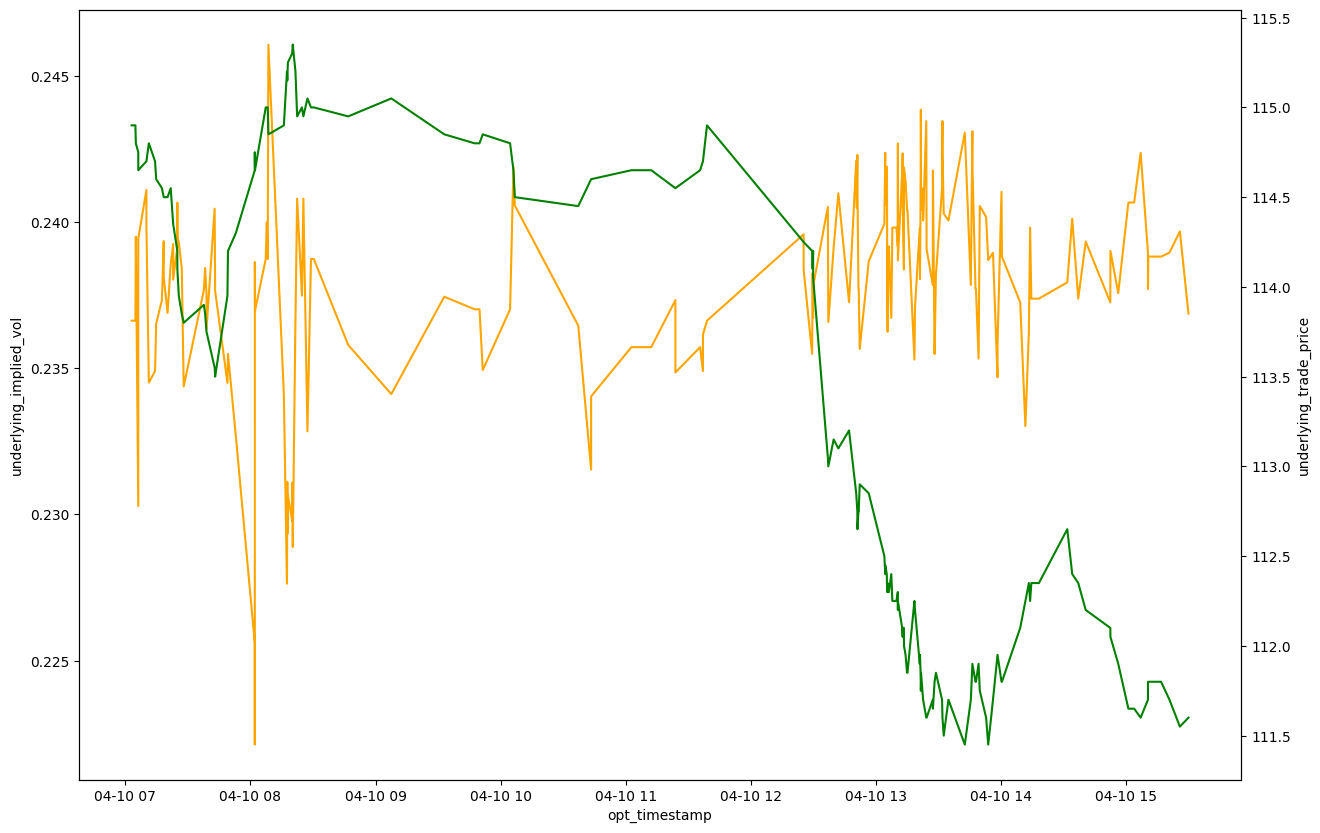

In [41]:
# df['lr']= np.log(df.underlying_trade_price.pct_change()+1)
fix, ax1 = plt.subplots(figsize=(15,10))
sns.lineplot(df, x = 'opt_timestamp', y = 'underlying_implied_vol', color = 'orange', ax = ax1)
ax2 = ax1.twinx()
sns.lineplot(df, x = 'opt_timestamp', y = 'underlying_trade_price', color = 'green', ax = ax2)
plt.show()